# Intermediate Python II

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [2]:
name='Hampus Naumanen'

During the previous datalab we learnt about the basic principles of numpy, matplotlib, scipy, and reviewed how to perform pattern searh with regular expressions. 

In this datalab we progress further and learn about several things. 

1. We will review how to write a class in python (our first step towards object oriented programming). Although you will not be required to build classes during this course,  later when we will use the OpenMC Monte Carlo particle transport code, it will be adventageous if you have a basic understanding of classes. Also most python packages provide an API where the understanding of classes is inevitable.

2. There are several data formats or markup languages to store data, here we will get acquinted with three which is often used in nuclear engineering software and for nuclear data:
    - csv: comma separated values
    - XML: eXtensible Markup Language
    - JSON: JavaScript Object Notation

3. We will learn about an other mainstream standard libary: pandas, which is often used for data analysis. The reason we will need some basic idea about this package is that we will later extract OpenMC results as pandas DataFrames.

4. We will learn how to use python as an internet browser!
5. Finally we review how to install and use not mainstream python packages. 

So let's get started.

## Class

A Class is a collection of data and functionality. It allows us to define a new type of object, and after the Class definition we can create new instances of that class. An instance will have **attributes** (variables describing the state of the instance) and **methods**, functions which allow us to modify the state of the instance.

As with everything else in Python, there is no "best" way to define and use classes, here we are presenting only one general solution, and we are omitting the demonstration of several functionality (for example inheritence). We however encourage you to further develop your understanding with reading the official [python site](https://docs.python.org/3/tutorial/classes.html).

Let's try to make this more clear with an example. Consider that we are writing a program, in which we often define materials (for example for a reactor physics application). The materials are being described by the nuclide content, and the density (attributes), and it has some methods to modify these attributes. We can define a class with the `class` keyword, which is then followed by statements. A class can have a special method `__init__`, which will be executed when an instance of the class is created, to create an initial state. Our class also has an other special method `__repr__`, which returns the object representation in string format. None of this is mandatory. Besides these we defined three methods to add nuclides, set the density or to convert the density to other units. One could access and update the state of the instance directly with for example `myMaterial.density = 10.0`, but it is often better programming practice to define function to do such updates. Notice that all the methods have a parameter `self`, this is how you refer to the instance itself, and when you call `myMaterial.set_density(10.0)`, then infact `myMaterial` is also an input of the method. 

In [6]:
class Material:
    """A class used to represent a Material.
    Parameters
    ----------
    nuclides : dict
      Dictionary to store nuclides. Keys nuclide identifiers, values atomic fraction.
    density : dict
      Density of material in g/cm3
    Attributes
    ----------
    nuclides : dict
        Dictionary to store nuclides. Keys nuclide identifiers, values atomic fraction.
    density : float
        Density of material in g/cm3
    """

    def __init__(self, nuclides={},density=None):
        """Function to initialize an instance of Material()"""
        self.nuclides = nuclides
        self.density = density
        
    def __repr__(self):
        if self.density is None:
            return "This is a material with no specified density"
        else:
            return "This is a material with density %.2f" %self.density

    def add_nuclide(self, symbol, fraction):
        """The method adds or updates the atomic fraction of a nuclide.
        
        Parameters
        ----------
        symbol : str
            Symbol of the nuclide (eg. U-238)
        fraction : float
            Atomic fraction of the nuclide.
        """
        self.nuclides[symbol]=fraction
        
    def set_density(self, density=None):
        """Method to set the density of the Material.
        
        Parameters
        ----------
        density : float
            density of material in g/cm2
        """
        self.density=density
        
    def get_density(self,unit='g/cm3'):
        """Method to get the density of the instance."""
        if self.density is None:
            raise ValueError('Density is not specified yet')
        elif unit=='g/cm3':
            return self.density
        elif unit=='kg/m3':
            return self.density*1000
        else:
            ValueError('Only g/cm3 and kg/m3 are available')
    
        

Let's create an instance of our `Material()` class.

In [3]:
iron=Material()

In [4]:
iron

This is a material with no specified density

But we can create an Material instance by immediately specifying the atomic percentages of nuclides and the density.

In [5]:
aluminium = Material({'Al27': 0.5, 'Al25': 0.5},density=3.6)

In [6]:
aluminium

This is a material with density 3.60

In [7]:
aluminium.get_density(unit='kg/m3')

3600.0

In [8]:
iron.set_density(6.3)

In [9]:
iron

This is a material with density 6.30

In [10]:
iron.add_nuclide('Fe55',0.02)

In [11]:
iron.nuclides

{'Fe55': 0.02}

That's about what you have to know about classes for this course.

Now let's move onto an other topic and review various data formats often used to store data.

## Data formats

When writing a software producing data we often want to export it in some format. Some legacy nuclear engineering codes would produce lengthy ASCII files, which are easy to read as a human, but as we saw before might be tricky to read with a computer. To overcome this it us better to export our data into standardized formats which are easy to interpret. Of course there are plenty of such formats to pick from, and we do not intend to review all of them. Notably, we are not going to look into the [hierarchical data format (HDF)](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) which became rather popular recently to store large amount of data (and as we will see later openMC also exports all data into hdf5 files). 

We will however take a look at some "simpler" (ie. readable by humans) formats: like JSON, csv, XML, which are often used in nuclear engineering applications. Along this notebook you will find three example files named '03-sample.json','03-sample.xml' and '03-sample.csv'. Although we will look into how to read this files with python, it is also important that you just visually inspect them with a text editor.

The power of these standardized formats is that most of the programming languages provide readily available libraries and functions to parse these formats. So it is simple to transfer data between various applications.

### JSON

JSON stands for JavaScript Object Notation, and is a standard file format which uses human-readable text to store data object consisting of attribute-value pairs and arrays. Remember dictionaries and lists? Dictionaries were attribute (key)-value pairs, and lists were arrays. So although JSON originates from JavaScript, in fact the syntax of the JSON format resembles the syntax of python. 

Just to appriciate even more why is it worth learning about JSON: after this lecture you will be well prepared to write your own scripts to visualize various aspects of [Covid-data](https://covid.ourworldindata.org/data/owid-covid-data.json), what maybe others have not thought of yet.

The file '03-sample.json' contains the results of a calculation where a piece of iron was irradiated with 14 MeV neutrons (the file was created with an activation and transmutation code called FISPACT-II, later during the course we will learn more about transmutation calculations). If we review the contant of the file, we see that indeed it very much looks like a dictionary with keys called `run_data` and `inventory_data`, and storing lists and nested dictionaries as values.

```json
    {
      "run_data": {
        "timestamp": "16:03:07 20 April 2021",
        "run_name": "* Iron irradiation",
        "flux_name": "Neutron generator Spectrum"
      },
      "inventory_data": [
        {
          "irradiation_time": 0.0E+0,
          "cooling_time": 0.0E+0,
          "flux": 0.21733749239999996E+7,
          "total_heat": 0.0E+0,
          "alpha_heat": 0.0E+0,
          "beta_heat": 0.0E+0,
          "gamma_heat": 0.0E+0,
          "ingestion_dose": 0.0E+0,
          "inhalation_dose": 0.0E+0,
          "dose_rate": {
            "type": "",
            "distance": 0.0E+0,
            "mass": 0.0E+0,
            "dose": 0.0E+0
          },
          "nuclides": [
            {
              "element": "Fe",
              "isotope": 54,
              "state": "",
              "half_life": 0.0E+0,
          ...
```

So let's go ahead and open this file! Hopefully you are not going to be surprised that for this we are going to use the python package called `json`.

In [8]:
import json
with open('03-sample.json') as json_file:
    inventory = json.load(json_file)

Wow, that was it! It was as simple as reading a file with `read()`. Now we have a dictionary storing everything. Pretty cool, huh? 

Shall we take a look into the content?

In [9]:
inventory.keys()

dict_keys(['run_data', 'inventory_data'])

I will actually tell you that `inventory['inventory_data']` is a list containing some data (activity of the irradiated material, and the nuclides in the material) at certain irradiation steps. So you of course have to know the basic structure of your JSON file to make sense out of it, and reach the content you really want to work with. And if it is a large amount data nested deeply, this takes some thinking (but the good news is that you are university students, so thinking is part of the deal!). And you might end up with some pretty nasty looking indexing. 

For example this is the mass of Fe-54 after 7200 s (90 mins) of irradiation. One needs to review first the JSON file (either with a script or by reading it) to know that the first index goes through the time steps, and the second goes through the nuclides.

In [14]:
#           index 4 belongs to 7200 s   index 19 is Fe-54
inventory['inventory_data'][4]['nuclides'][19]['grams']

2.275567428301899e-18

And this file is not even that bad!

If we have a dictionary writing it into a JSON file is also simple:

```python
    with open('myfile.json', 'w') as outfile:
    json.dump(myDict, outfile, indent=4)
```

But let's leave JSON files behind for now, and start to look at an other format.

## XML

XML stands for eXtensible Markup Language and defines rules for encoding data in format which is both human-readable and machine-readable. One can define attributes and elements within starting and closing tags, and also atributes between empty-element tags. XML is a bit more difficult to interpret than a JSON format. The main reason we take a quick look at XML is because openMC has XML inputs. Nevertheless, we will not interact with openMC through these inputs, but through a python API. 

An example openMC input looks like '03-sample.xml'. This file describes materials for the code. We have a main or parent tag (`<materials>`), which has children tags (`<material>`) etc. This input defines three materials: `uo2` (uranium-dioxide, $UO_2$) with density 10.5 g/cm3 containing the isotopes U235, U238 ad O16, `zirconium` with density 6.6 g/cm3 containing various zirconium isotopes, and `h2o` (water) with density 0.75 g/cm3 made of H1 and O16.

```xml
    <?xml version='1.0' encoding='utf-8'?>
    <materials>
      <material depletable="true" id="1" name="uo2">
        <density units="g/cm3" value="10.5" />
        <nuclide ao="0.04" name="U235" />
        <nuclide ao="0.96" name="U238" />
        <nuclide ao="2.0" name="O16" />
      </material>
      <material id="2" name="zirconium">
        <density units="g/cm3" value="6.6" />
        <nuclide ao="0.1122" name="Zr91" />
        <nuclide ao="0.028" name="Zr96" />
        <nuclide ao="0.1715" name="Zr92" />
        <nuclide ao="0.1738" name="Zr94" />
        <nuclide ao="0.5145" name="Zr90" />
      </material>
      <material id="3" name="h2o">
        <density units="g/cm3" value="0.75" />
        <nuclide ao="2.0" name="H1" />
        <nuclide ao="1.0" name="O16" />
        <sab name="c_H_in_H2O" />
      </material>
    </materials>
```

Parsing such a file is a bit trickier (lucky that you will not need to do it too much!), and can be done with the `xml.etree.ElementTree` module.

In [15]:
import xml.etree.ElementTree as ET
import re
tree = ET.parse('03-sample.xml')
root = tree.getroot()

In [16]:
root

<Element 'materials' at 0x000001B252A63C70>

We are not much smarter! Apparently root is some sort of instance of an object. And not the values stored in it. Somehow we have to access it. If we make a list of it, we just seem to get several other "Element" objects. Then they need to have some attributes!

In [17]:
list(root)

[<Element 'material' at 0x000001B252A07E00>,
 <Element 'material' at 0x000001B252A779F0>,
 <Element 'material' at 0x000001B252A77C20>]

In [18]:
root[0].attrib

{'depletable': 'true', 'id': '1', 'name': 'uo2'}

In [19]:
list(root[0])

[<Element 'density' at 0x000001B252A07310>,
 <Element 'nuclide' at 0x000001B252A77900>,
 <Element 'nuclide' at 0x000001B252A77950>,
 <Element 'nuclide' at 0x000001B252A779A0>]

In [20]:
root[0][0].attrib

{'units': 'g/cm3', 'value': '10.5'}

Heureka, the `root` contains three 'material' elements, and apparently we can access the attributes of those as dictionaries! Also we see that the 'material' elements have further elements, which have attributes.

It's like going through a tree and picking different branches to find the final leaf which contains the data we need. Let's try to print the material names and their densities.

In [21]:
for child in root:
    name=child.attrib['name']
    for grandchild in child:
        if 'value' in grandchild.attrib:
            density=grandchild.attrib['value']
            print(name,density)

uo2 10.5
zirconium 6.6
h2o 0.75


Well, this was not very straightforward, but one can get used to it! If you are interested in exploring the further beauties of XML, there is an example in the notebook demonstrating how to create the first chapter's plots where an even more complex XML file is parsed.

But for today I think we all agree that are head is overwhelmed with XML, so let's get back to simpler formats.

## csv

Csv stands for comma separated values, and is a very straightforward, although not full standardized format. Essentially the file contains data records (rows), and a record contains one or more fields (columns), separated by comma. You can imagine it as a typical spreadsheet (in fact in most systems csv files will by default be opened by spreadsheet applications). 

Let's take a look at '03-sample.csv'. This file stores the concentration (in $\text{cm}^{-1}\text{barn}^{-1}$ units) of some nuclides for uranium-dioxed fuels with various initial enrichment (IE), irradiated for various time length (BU: burnup), and cooled for different times (CT) calculated with a software called Serpent2. We will learn later more about the fuel evolution, and how to calculate such concentrations. For now the important part is to notice, that the first column seems to be a header, describing "keys" for each column. The following rows contain the data (one record belongs to one fuel). 

```
    ,BU,CT,IE,Cs134,Cs137,Eu154,U235,Pu239
    0,23,3102.5,1.5,1.88424E-07,2.84566917879002E-05,2.69679813433217E-07,8.22522171634031E-05,0.000121476
    1,30,7482.5,1.5,5.20168E-09,2.79799245808655E-05,1.52985963215638E-07,5.42325572566305E-05,0.000129026
    2,37,4197.5,1.5,1.45199E-07,4.21499771616296E-05,4.17562528731865E-07,3.59841349105039E-05,0.000134992
    3,52.5,6752.5,1.5,2.16965E-08,4.9979226189458E-05,3.50484414413579E-07,1.50402501420245E-05,0.00014544
    4,65.5,3102.5,1.5,8.08478E-07,7.74388092788155E-05,9.6942317979626E-07,7.48810453458104E-06,0.00015283
    5,30,91.25,1.6,4.63841E-06,4.46352992585013E-05,7.77532100448014E-07,6.15403234287554E-05,0.0001299283
    6,34.5,8395,1.6,2.7162412E-09,3.01868876171812E-05,1.5011569350238E-07,4.75259853623482E-05,0.00013365
    7,57,1368.75,1.6,3.42660E-06,7.59309237451187E-05,1.25129574849322E-06,1.35365167615274E-05,0.00014867
    8,57,5840,1.6,5.59338E-08,5.7224184909055E-05,4.66071542695002E-07,1.35888359894115E-05,0.000148643804
    9,27.5,365,1.7,3.08791E-06,4.02748433202162E-05,6.37972051142385E-07,8.0098420206549E-05,0.00012842678
    10,35,7847.5,1.7,4.55574E-09,3.16746996946991E-05,1.7181072908398E-07,5.23717817097577E-05,0.000134991
```

We could read csv files with the built-in csv reader (and interested readers can follow [this tutorial](https://realpython.com/python-csv/)). We can also use the `numpy.loadtxt` function we learnt about last time, just now by setting the delimiter to ',' and skipping the header row:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
fuelmatrix=np.loadtxt('03-sample.csv',delimiter=',',skiprows=1)
fuelmatrix

array([[0.00000000e+00, 2.30000000e+01, 3.10250000e+03, ...,
        2.69679813e-07, 8.22522172e-05, 1.21476068e-04],
       [1.00000000e+00, 3.00000000e+01, 7.48250000e+03, ...,
        1.52985963e-07, 5.42325573e-05, 1.29026600e-04],
       [2.00000000e+00, 3.70000000e+01, 4.19750000e+03, ...,
        4.17562529e-07, 3.59841349e-05, 1.34992514e-04],
       ...,
       [1.97000000e+02, 4.60000000e+01, 7.30000000e+02, ...,
        1.07336616e-06, 4.99336878e-04, 1.91230616e-04],
       [1.98000000e+02, 4.95000000e+01, 7.84750000e+03, ...,
        2.49743662e-07, 4.54579917e-04, 1.94033925e-04],
       [1.99000000e+02, 5.05000000e+01, 6.02250000e+03, ...,
        3.82509656e-07, 4.42275314e-04, 1.94694090e-04]])

Now we remember from before how to access given columns of this 2D numpy array, and we can go ahead and plot the Uranium-235 (index 7) content against the burnup (index 1).

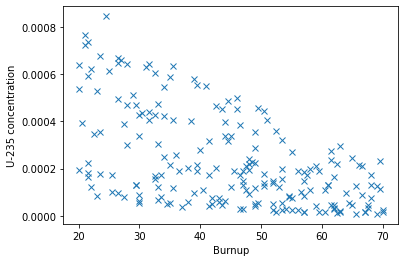

In [23]:
plt.figure()
plt.plot(fuelmatrix[:,1],fuelmatrix[:,7],'x')
plt.xlabel('Burnup')
plt.ylabel('U-235 concentration')
plt.show()

We see that there is a general trend that with increasing burnup (more time under irradiation) we have less U-235 (since we loose it in fission event as we will learn more about this). The markers are not aligned along a straight line, because each marker belongs to a fuel with a unique initial enrichment.

This works pretty well, but apparently we lost the information about the header, so we need to keep in mind the right index for the columns (or have some workound which maps the columns to the right key). This is fine when we have few columns but what if we have hundreds?

To resolve this, now we will look into an other mainstream data analysis library called pandas, which has a data container called DataFrame which combines the power of numpy arrays and dictionaries!

## pandas

Pandas is a data analysis and manipulation tool. The main reason we have to take a look at it (besides it being very powerful) is that later we will handle openMC results as pandas DataFrames.

We will use the `read_csv` method of pandas to read in the '03-sample.csv' file as a DataFrame, and look at the basic functionality. Notice that we can specify which row contains the header information (so we will be able to refer to the columns with keys) and we can preselect the columns which we would like to import. DataFrames will be rendered as nice looking tables in jupyter.

In [25]:
import pandas as pd

fueldata=pd.read_csv('03-sample.csv',header = 0, usecols=['BU','CT','IE','Cs137','U235'])

Repeating the same plot as before can be done without remembering the index of the columns.

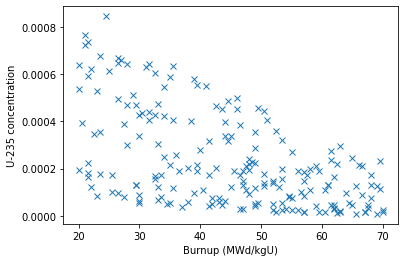

In [26]:
plt.figure()
plt.plot(fueldata['BU'],fueldata['U235'],'x')
plt.xlabel('Burnup (MWd/kgU)')
plt.ylabel('U-235 concentration')
plt.show()

We can filter certain parts of the dataset similarly as we learnt for numpy arrays previously. This is to be done by applying conditions. For example if we would like to filter a subset of fuels for which $40<BU<50$, we can do the following:

In [27]:
subfuel=fueldata[(fueldata['BU']>40) & (fueldata['BU']<50)]
print(len(subfuel))

subfuel.head()

45


,BU,CT,IE,Cs137,U235
11,46.5,8942.50,1.7,0.000039,0.000028
18,41.5,10037.50,1.8,0.000032,0.000041
19,47.0,4015.00,1.8,0.000054,0.000030
27,42.0,1277.50,2.0,0.000057,0.000051
28,43.5,1368.75,2.0,0.000059,0.000047


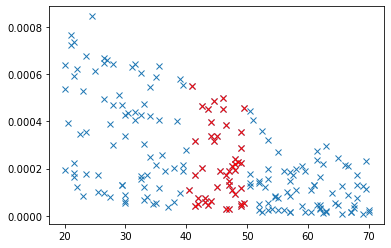

In [28]:
plt.figure()
plt.plot(fueldata['BU'],fueldata['U235'],'x')
plt.plot(subfuel['BU'],subfuel['U235'],'rx')
plt.show()

Pandas provides a lot of further functionality (remember, with hitting TAB on `fueldata.` you can list the available methods), which are relevant for data analysis, although in this course we will not use them. Just to demonstrate its further power let see how we can calculate the correlation of the different parameters:

In [29]:
fueldata.corr()

,BU,CT,IE,Cs137,U235
BU,1.000000,-0.016936,-0.016857,0.836145,-0.558210
CT,-0.016936,1.000000,0.021718,-0.537265,0.013064
IE,-0.016857,0.021718,1.000000,-0.042921,0.778243
Cs137,0.836145,-0.537265,-0.042921,1.000000,-0.480398
U235,-0.558210,0.013064,0.778243,-0.480398,1.000000


This table gives us the correlation matrix. What we see is that the diagonal is filled with ones. Of course, since a parameter is fully correlated to itself. Due to similar considerations the matrix is symmetric along the diagonal. We can also notice that the BU, CT and IE parameters are not correlated, which is not surprising. What we can however notice is that the Cs-137 content is strongly correlated to the burnup (the longer the fuel is irradiated, the more is created, as we will see in later lectures), and is strongly correlated (even if the value is negative) to the cooling time (the longer the fuel is cooled, the the more Cs-137 has decayed away). How would you interpret the correlation of U235 to the other parameters?

So this is very neat, you did a great job and learnt about several data storage options, if you invest some time and practice into this topic you will be simply awesome!

But now let's turn our attention to a slightly different topic.

## Browsing the internet

Let's be honest, we do spend an awful lot of time on the internet, watching cat videos, and sometimes digging up nuclear data. It would be just nice if we could automatize part of this. Let's say that the part we want to automatize is the digging nuclear data (the cat video waching part would be also nice, but it is outside of the scope of this course). The way how we access data from the internet is most often with a browser: we type in a URL, and based on that our browser sends a request to a server (with the GET method of the Hypertext Transfer Protocol) containing the data we are interested in, then the data is sent back to us, and the browser renders it. But actually we can do the same with python, for example with the `urllib.request` package. And how it is implemented is not different at all from how we would read a file on our computer.

Let's try to access the U-235 fission cross section data from the KAERI site. Note, that this might take few seconds depending on your connection. In case the connection times out, just try to run it again. 

In [17]:
import urllib.request

website='http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'

with urllib.request.urlopen(website) as response:
    content235 = response.readlines()

In [18]:
content235[:15] #inspect the first 15 lines

[b'<html><body bgcolor=#DEDEDE><center><img src="/websray/wbs_error_response.gif"  border="0" ></center></body></html>\r\n',
 b'\r\n',
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

So the data received is in HTML. In order to make any sense of it, we will need to parse it. There are some readily available parsers for HTML (a popular one is called Beautiful Soup), but since we are not going to parse very difficult HTML code, instead of overwhelming ourselves by reviewing yet an other parser library, I just provide you with a function which can extract the data:

In [15]:
def getXS(content):
    """Function to extract data from the html content provided by KAERI.
    the content has a shape as follows like:    
    Energy(eV) XS(b)<br>
    1.00000E-05 3.07139<br>"""
    energy=[]
    xs=[]
    flag=False
    i=0
    for line in content:
        x=line.strip().split()
        if  x[0]==b'Energy(eV)':
            flag=True
            continue
        if x[0]==b'</span>':
            flag=False
        if flag:
            energy.append(float(x[0]))
            xs.append(float(x[1][:-4]))
    return np.array(energy), np.array(xs)

In [16]:
energy,xs=getXS(content235)

plt.figure()
plt.loglog(energy,xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (barn)')
plt.show()

IndexError: list index out of range

And we can do a lot more! We could download zip files, extract the content etc. The important take away message here is, that with python any file manipulation, even it is stored somewhere on the world wide web, can be done relatively easily. Should you have any idea like that, just search and you will find solutions to it. 

## Installing and using other packages

It was mentioned a lot of times that you can find several packages, and use them. But how to do that? It is fairly simple. Once you found the package you can install it with the python package installer `pip` (or with `conda`, depending on how you installed python), which you can run from your terminal or command prompt. Some packages are registered to [PyPI](https://pypi.org/) the Python package index, these you can simply install with `pip install nameofpackage`. There are some which are not registered at PyPI and deployed at some other site, like github. These you can usually install with `pip install urlofpackage`. Nevertheless, any well maintained package will let you know how to to install it, and you just have to follow that. Also a well maintained package will include a 'setup.py' file, which lists the dependencies of the package (for example that it requires NumPy), from which `pip` will figure out whether any other dependent packages need to be installed as well.

As a typical example we can take a look at a package called `radioactivedecay`: https://pypi.org/project/radioactivedecay/. The site clearly describes that you can install it with `pip install radioactivedecay`. Once that is done, you can import the package in your scripts. Also the developer has to provide examples, which with the knowledge you have acquired up to now, you can easily follow. For example the usage of this package is the following:

```python
    >>> import radioactivedecay as rd
    >>> inv_t0 = rd.Inventory({'Mo-99': 2.0})
    >>> inv_t1 = inv_t0.decay(20.0, 'h')
    >>> inv_t1.contents
    {'Mo-99': 1.6207863893776937,
    'Tc-99': 9.05304236308454e-09,
    'Tc-99m': 1.3719829376710406}
```

First, you import the library. Then, you create an instance of the `Inventory()` class, which takes a dictionary as parameter containing the activity of isotopes. Then, you call the `.decay()` method while specifying the decay time, and you can `contents` of the inventory after the decay time elapsed. 

Since most of the python packages are open source, you can build on them, or modify them if you find that some functionality is missing. 

Again, the take away message here is, that if you have a problem to solved, do not hesitate to first look for a package which already solves it.

# Exercises 

## 1

Extend the `Material()` class by including a method which converts the mass density to atom density. First, renormalize the atomic fractions to make sure that it sums to 1. Then use `re` to get the atomic number of the nuclides in the nuclide vector. 

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 19 20:42:02 2021

@author: Hampus
"""

import re
import functools

class Material:
    """A class used to represent a Material.
    Parameters
    ----------
    nuclides : dict
      Dictionary to store nuclides. Keys nuclide identifiers, values atomic fraction.
    density : dict
      Density of material in g/cm3
    Attributes
    ----------
    nuclides : dict
        Dictionary to store nuclides. Keys nuclide identifiers, values atomic fraction.
    density : float
        Density of material in g/cm3
    """

    def __init__(self, nuclides={},density=None):
        """Function to initialize an instance of Material()"""
        self.nuclides = nuclides
        self.density = density
        
    def __repr__(self):
        if self.density is None:
            return "This is a material with no specified density"
        else:
            return "This is a material with density %.2f" %self.density

    def add_nuclide(self, symbol, fraction):
        """The method adds or updates the atomic fraction of a nuclide.
        
        Parameters
        ----------
        symbol : str
            Symbol of the nuclide (eg. U-238)
        fraction : float
            Atomic fraction of the nuclide.
        """
        self.nuclides[symbol]=fraction
        
    def set_density(self, density=None):
        """Method to set the density of the Material.
        
        Parameters
        ----------
        density : float
            density of material in g/cm2
        """
        self.density=density
        
    def get_density(self,unit='g/cm3'):
        """Method to get the density of the instance."""
        if self.density is None:
            raise ValueError('Density is not specified yet')
        elif unit=='g/cm3':
            return self.density
        elif unit=='kg/m3':
            return self.density*1000
        else:
            ValueError('Only g/cm3 and kg/m3 are available')
            
    def massDToAtomD(self):
        """
        

        Raises
        ------
        ValueError
            When the atomic fractions does not equal one.

        Returns
        -------
        atomicDensity : float
            The number of atoms per cm^3

        """
        sum = 0
        atomicMolarList = []
        NA = 6.022*10**23       #Avogadros number
        for key in self.nuclides:
            sum += self.nuclides[key]
            
        if sum != 1:
            raise ValueError(f'The total atomic fraction is equal to: {sum}, but should be equal to 1.')
        else:
            for key,value in self.nuclides.items():
                temp = re.findall(r'\d+', key)              #find the number i.e '27' in the string 'Al27'
                res = list(map(int, temp))                  #map it to list as int
                atomicMolarList.append(res[0]*value)        #weighted list of molarmass for every istotope
            atomicDensity = self.get_density()/(functools.reduce(lambda a, b: a+b, atomicMolarList))*NA     #calculate the atomic density
        return atomicDensity
    
    """
    
    (densitet / summan av den viktade molmassan) * avagadros nummer = atomdensiteten
    
    """
            
            
def main():
    iron = Material()
    print(iron)
    aluminium = Material({'Al27': 0.5, 'Al25': 0.5},density=3.6)
    print(aluminium)
    print('Atom density of aluminium: ', aluminium.massDToAtomD())
    uranium = Material({'U238': 1}, density=19.05)
    print('Atom density of Uranium: ', uranium.massDToAtomD())
    potassium = Material({'K39': 0.9213, 'K40': 0.0117, 'K41': 0.067}, density = 0.89)
    print('Atom density of potassium: ', potassium.massDToAtomD())
    
    
if __name__ == "__main__":
    main()

This is a material with no specified density
This is a material with density 3.60
Atom density of aluminium:  8.338153846153846e+22
Atom density of Uranium:  4.82013025210084e+22
Atom density of potassium:  1.369136329149817e+22


## 2

Inspect the '03-sample.json' file. Extract the ingestion dose values (`ingestion_dose`) over time, and extract the time. Notice that after a while the irradiation ended, and the `inventory['inventory_data'][i]['irradiation_time']` values do not increase, however the target was let to cool (ie. undergoes decay), and the `inventory['inventory_data'][i]['cooling_time']` increases (the values are in second). Find out the total elapsed time. Try to use list comprehension (see 1st datalab) to extract both the ingestion dose and time with one line of code.

In [3]:
def extractJsonData():
    import json
    with open('C:/Users/Hampu/Documents/PythonProggII/ComputationalReactorPhysics/Datalabs_tasks/Datalabs/Datalab03/03-sample.json') as json_file:
        inventory = json.load(json_file)
        
        
    ingestionAndTimeValues = [(inventory['inventory_data'][i]['ingestion_dose'],\
                               inventory['inventory_data'][i]['irradiation_time'],\
                               inventory['inventory_data'][i]['cooling_time'])  \
                              for i in range(len(inventory['inventory_data']))]
    return ingestionAndTimeValues
        
def calcTime(data):
    sumTime = 0
    for i in range(len(data)):
        if data[i][1] != data[i-1][1]:
            sumTime += data[i][1]
        else:
            sumTime += data[i][2]
    return sumTime

def main():
    data = extractJsonData()
    print('The total time (in seconds): ', calcTime(data))
    
    
if __name__ == "__main__":
    main()

The total time (in seconds):  9403860.0


## 3

Use the '03-sample.csv' dataset, and filter it to get a subset of fuels for which $40<BU<50$, $2.5<IE<3.5$ and $10y<CT<20y$. How many of such samples are available (Note, that the cooling time is given in days in the dataset)

In [10]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 22 19:37:21 2021

@author: Hampus
"""

import pandas as pd

fueldata=pd.read_csv('C:/Users/Hampu/Documents/PythonProggII/ComputationalReactorPhysics/Datalabs_tasks/Datalabs/Datalab03/03-sample.csv',header = 0, usecols=['BU','CT','IE','Cs137','Eu154','U235','Pu239'])


subfuel=fueldata[(fueldata['BU']>40) & (fueldata['BU']<50) & (fueldata['IE']>2.5) & (fueldata['IE']<3.5) & (fueldata['CT']>3065) & (fueldata['CT']<6130)]

print(subfuel)
print()

print('Number of fuels that fulfill the above conditions are : ', len(subfuel))





      BU      CT   IE     Cs137         Eu154      U235     Pu239
66  48.0  3650.0  2.9  0.000056  6.266948e-07  0.000090  0.000155
80  47.0  3650.0  3.3  0.000054  6.088841e-07  0.000129  0.000159

Number of fuels that fulfill the above conditions are :  2


Your conclusion comes here.

## 4 

Notice that the URL we used to access cross section data has some numbers in it: 'http://atom.kaeri.re.kr/nuchart/getData.jsp?target=jeff3.2,92,235,9228,3,18'. You probably figured out that the number 92 is the Z, and 235 is the A. The other data also has some meaning. 9228 is something called the MAT number, 3 is the MF number, and 18 is the MT number. Scientists working on nuclear data just like to have everything in order! The MAT number refers to the nuclide, the MF number refers to the type of data (MF=3 stands for cross section vs energy), and the MT number describes the reaction type (MT=18 is fission, MT=1 is total cross section). That said, it seems we can create automatically strings describing urls to reach various cross section data. And that is exactly what we are going to do now!

You have the following dictionary storing MAT and MT numbers (MF should be always 3), try to write a `for` loop to iterate through them and use `urllib.request` to download the HTML code describing the data, Then use the previously defined `getXS()` function to extract the energy and cross section data, and update the empty lists with that (eg. `data['Pu239fiss']['xs']=...`). Plot each cross section in the same figure. Which isotope of plutonium seems to be fissile?

In [ ]:
data={'Pu239fiss': {'Z':94, 'A':239,'MAT':9437,'MT':18,
                  'energy':[],'xs':[],'col':'r-'},
      'Pu239tot': {'Z':94, 'A':239,'MAT':9437,'MT':1,
                  'energy':[],'xs':[],'col':'r--'},
      'Pu240fiss': {'Z':94, 'A':240,'MAT':9440,'MT':18,
                  'energy':[],'xs':[],'col':'b-'},
      'Pu240tot': {'Z':94, 'A':240,'MAT':9440,'MT':1,
                  'energy':[],'xs':[],'col':'b--'},
      'Pu242fiss': {'Z':94, 'A':242,'MAT':9446,'MT':18,
                  'energy':[],'xs':[],'col':'g-'},
      'Pu242tot': {'Z':94, 'A':242,'MAT':9446,'MT':1,
                  'energy':[],'xs':[],'col':'g--'}}

#your code comes here

Your conclusion comes here.

## 5

Open a terminal window (if you are using the virtual machine, otherwise a command prompt), and install the package called `radioactivedecay`, and then after importing it, execute the examples from https://pypi.org/project/radioactivedecay/.

(Note that you might need to restart jupyter for the installation take effect, make sure to save your work first.)

In [ ]:
#your code comes here